In [ ]:
!pip install "numpy<2.0.0" --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 51.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import os
os._exit(00)

In [10]:
#VERIFICAR SEMPRE QUE NUMPY=1.2.6 !! (instal.lar numpy , guardar, f5 i comprovar)

import numpy as np
print(np.__version__)

1.26.4


In [ ]:
#DOWNLOAD ESSENTIA (sii numpy=1.2.6)
# Instalación base
!pip install essentia
!apt-get install -y ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 62.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
#!pip install crepe librosa soundfile pandas
#import crepe

In [ ]:
import essentia
import essentia.standard as es
import librosa
import numpy as np
import pandas as pd
import os
import json

In [ ]:
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

drive_folder = '/content/drive/MyDrive'
print(os.listdir(drive_folder))

Mounted at /content/drive
['Belbin_TEMPLATE_ES.gsheet', '2023 24', 'Seminar 1 - Jesús Pavón 206933.xlsx', 'Diagrama sin título.drawio', 'Datasets_analysis_and_EDA_v2.6.ipynb', 'Team102G.Increment#1Model.v0.0.ipynb', 'jesus_pavon_garcia_206933.gdoc', 'Document sense títol (1).gdoc', '206933_jesus_pavon_garcia.gdoc', 'semi.3.4.ipynb', 'Individual Assessment for Presentations(2nd round).gdoc', 'Document sense títol.gdoc', '2281967212 - ORIOL SOLER GONZÁLEZ -C.pdf', '2315185305 - LUCÍA PLASENCIA ORTEGA - C.pdf', '2315185305 - LUCÍA PLASENCIA ORTEGA - C.gdoc', 'Colab Notebooks', '2024 25', 'Untitled0.ipynb', 'Report3_Jesús_Pavón_206933.gdoc', 'Untitled document.pdf', 'lab3_enhancement.ipynb', 'Memoria_TIC_jesus_pavon_206933.docx']


In [11]:
#DATASET FROM WAV FILES using ESENTIA
def data_extractor(audio_path, hop_size=128, sample_rate=48000, frame_size=2048): #hop=128 , sample_rate=48000 frame_size=2048
    # Ruta al archivo de audio carga un arxiu
    #audio_path = os.path.join(drive_folder, 'Bagpipes', 'samples', 'AudioSet', 'Balanced Train', 'sample_bt_40.wav')
    #hop_size = 128  # Valor predeterminado en Essentia 128
    #sample_rate = 48000
    #frame_size = 2048 #standard 2048 no dona resultats accurate

    # Cargar el audio y aplicar el filtro de igual sonoridad
    loader = es.MonoLoader(filename=audio_path, sampleRate=sample_rate)
    audio = loader()
    equal_loudness = es.EqualLoudness()
    audio_eq = equal_loudness(audio)

    #Calcula melodia en tot el rang - f0 utiltzada per entrenar model
    pitch_extractor = es.PredominantPitchMelodia(
        frameSize=frame_size,
        hopSize=hop_size,
        minFrequency=80,
        maxFrequency=5000,
        filterIterations=3,
        magnitudeThreshold = 40,
        sampleRate=sample_rate
    )
    pitch_values, confidence = pitch_extractor(audio_eq)

    #Calcular nota DRONE separat
    # 2. Eliminar transitorios para quedarte solo con lo sostenido (el drone es continuo)
    envelope = es.Envelope()(audio)
    mask = envelope < 0.3  # filtra zonas con bajo nivel de energía (ajustar según señal)
    sustained = audio * mask.astype(float)

    # 3. Potenciar graves
    equalizer = es.EqualLoudness()
    sustained_eq = equalizer(sustained)

    # 4. Filtro pasa bajos para dejar solo graves
    lowpass = es.LowPass(cutoffFrequency=300.0)
    filtered = lowpass(sustained_eq)

    # Aplicar el algoritmo PredominantPitchKlapuri per melodia principal
    pitch_extractor_drone = es.PredominantPitchMelodia(
        frameSize=4096,
        hopSize=hop_size,
        minFrequency=80,
        maxFrequency=500,
        filterIterations=3,
        magnitudeThreshold =12,
        guessUnvoiced = True,
        sampleRate=sample_rate
    )


    pitch_values_drone, confidence_drone = pitch_extractor_drone(filtered) #només prova observar su capta millor f' greus
    #pitch_values_drone, _ = pitch_extractor_drone(audio_eq)

    #Calcular Key
    # Detectar tonalidad
    key_extractor = es.KeyExtractor(sampleRate=sample_rate)
    key, scale, strength = key_extractor(audio_eq)

    # Calcular los tiempos correspondientes a cada valor de pitch
    times = np.arange(len(pitch_values)) * hop_size / sample_rate
    duration_sec = len(audio) / sample_rate

    #LOUDNESS
    # Calcular RMS para cada frame
    rms_calc = es.RMS()

    rms_values = []
    for frame in es.FrameGenerator(audio, frameSize=frame_size, hopSize=hop_size):
        rms_val = rms_calc(frame)
        rms_values.append(rms_val)


    # Extreure el nom del arxiu
    filename = os.path.basename(audio_path)

    # Extreure origen desde el path (VARIAR SI LES DADES VARIEN)
    if "AudioSet" in audio_path:
        origen = "Youtube"
    elif "Gilles Sadowski KEY G" in audio_path:
        origen = "Gilles Sadowski"
    elif "Jack Lee Bagpipe Music Library" in audio_path:
        origen = "Jack Lee"
    elif "Gaita Asturiana" in audio_path:
        origen = "Red de museos etnográficos de Asturias"
    elif "Gaita Gallega" in audio_path:
        origen = "Consello da cultura Gallega"
    else:
        origen = "unknown"

    #TEST
    #print(f"Archivo: {filename}")
    #print(f"Origen: {origen}")
    return pitch_values,pitch_values_drone, rms_values, key, scale, strength, origen, filename, duration_sec, times


In [12]:
# EXTRAU LA NOTA MÉS COMÚ DELS VALORS DE PITCH DRONE

def calc_drone_note(pitch_values_drone):
    #indica NOTA PREDOMINANT  DRONE segons la nota més comú entre [0-500] hz
    if pitch_values_drone is None or len(pitch_values_drone) == 0:
      drone_note = "None"
      most_common_note = "None"  # o None, o lo que tenga sentido para ti
      return drone_note, most_common_note

    # 2. Convertir a array i filtrar valores > 0
    all_pitches = np.array(pitch_values_drone)  # muy importante
    valid_pitches = all_pitches[(all_pitches > 0) & (all_pitches < 500)]

    midi_notes = librosa.hz_to_midi(valid_pitches)
    if len(midi_notes) == 0:
      drone_note = "None"
      most_common_note = "None"
      return drone_note, most_common_note
    notes = np.round(midi_notes).astype(int)
    # 4. Contar totes les notes i obtené la més comú
    note_counts = Counter(notes)
    most_common_note, count = note_counts.most_common(1)[0]

    # 5. Convertir nota més comú a midi
    drone_note = librosa.midi_to_note(most_common_note)

    #print(f"La nota drone estimada es: {drone_note} (MIDI {most_common_note}, {count} apariciones)")
    return drone_note, most_common_note

In [ ]:
#TEST
#drone_note, most_common_note = calc_drone_note(pitch_values_drone)

La nota drone estimada es: B3 (MIDI 59, 516 apariciones)


In [13]:
#Genera .csv EN AQUEST ARXIU SIMPLEMENT ES GUARDA TIME/F0/LOUDNESS - esencials per entrenar model DDSP

def write_csv(csv_path,pitch_values,times,rms_values):

    # Crear DataFrame insertar els valors de f0 a una coolumna
    df = pd.DataFrame({'f0': pitch_values})
    # Afegir columna de temps
    df.insert(0, 'time', times)
    #Afegir nota drone
    #df.insert(2, 'drone_note', pitch_values_drone)
    #df.insert(3, 'drone_note', valid_pitches[0])
    #Añadir intenistat
    df.insert(2, 'loudness', rms_values)
    # Guardar resultats en un arxiu  CSV
    df.to_csv(csv_path, index=False)

    #print(f"Archivo data .csv generat correctament")

In [14]:
#Genera .json EN AQUEST ARXIU ES GUARDA LA RESTA DE METADADES Escala, tonalitat, força, estimació nota drone, origen i tassa de mostreig

def write_json(json_path, filename, pitch_values, duration_sec, sample_rate, key, scale, strength, drone_note, origen):
    info_dict = {
        "filename": filename,
        "duration_sec": round(duration_sec, 2),
        "sample_rate": sample_rate,
        "key": {
            "key": key,
            "scale": scale,
            "strength": round(strength, 2)
        },
        "drone note aprox": drone_note,
        "origen": origen
    }

    # --- GUARDAR A JSON ---
    with open(json_path, 'w') as f:
        json.dump(info_dict, f, indent=4)

    #print(f"Archivo data .json generat correctament")

In [32]:
#FUNCIÓ PER FER DOWNSAMPLING + CHUNK AUDIOS EN 4s (Ideal per entrenar DDSP)
import os
import librosa
import soundfile as sf

def segment_and_downsample(input_dir, output_dir, target_sr=16000, segment_seconds=4):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if not filename.endswith(".wav"):
            continue

        path = os.path.join(input_dir, filename)
        audio, sr = librosa.load(path, sr=target_sr)
        segment_len = int(segment_seconds * target_sr)

        n_segments = len(audio) // segment_len
        base_name = os.path.splitext(filename)[0]

        for i in range(n_segments):
            start = i * segment_len
            end = start + segment_len
            segment = audio[start:end]
            segment_filename = f"{base_name}_s{i}.wav"
            segment_path = os.path.join(output_dir, segment_filename)
            sf.write(segment_path, segment, target_sr)
    print("\n¡Proceso downsampling completat!")


In [ ]:
#SEGÜENT IMPLEMENTACIÓ
# Crida totes les funcions per a fer una extracció de les mostres de cada carpeta seleccionada
# Guarda en fitxer .json i .csv
# Plot a mode test

In [28]:
from pathlib import Path
from tqdm import tqdm

def get_and_write_data_from_audio(samples_root, data_root, sample_rate=44100):

    #LOOP PER OBTENIR LES METADADES EN TOTS EL ARXIUS DEL DIRECTORI
    total_wavs = len(list(samples_root.rglob("*.wav")))
    processed_count = 0
    pitch_values= []
    pitch_values_drone= []
    rms_values= []

    for wav_path in tqdm(samples_root.rglob("*.wav"), desc="Procesando WAVs"):

        # Extreure info cridant a data_extractor i cal_drone_note
        (
            pitch_values, pitch_values_drone, rms_values,
            key, scale, strength, origen, filename,
            duration_sec, times
        ) = data_extractor(str(wav_path), sample_rate)
        drone_note, midi_note = calc_drone_note(pitch_values_drone)

        # Ruta relativa desde "samples/"
        relative_path = wav_path.relative_to(samples_root)
        base_name = wav_path.stem

        # Carpetas mirall per CSV y JSON
        csv_dir = data_root / relative_path.parent / "csv"
        json_dir = data_root / relative_path.parent / "json"

        csv_dir.mkdir(parents=True, exist_ok=True)
        json_dir.mkdir(parents=True, exist_ok=True)

        # Paths completos per guardar
        csv_path = csv_dir / f"{base_name}.csv"
        json_path = json_dir / f"{base_name}.json"

        # Guardar
        write_csv(csv_path, pitch_values, times, rms_values)
        write_json(json_path, filename, pitch_values, duration_sec, sample_rate, key, scale, strength, drone_note, origen)

        # Incrementar contador y mostrar progreso en la misma línea
        processed_count += 1
        #tqdm.write(f"Procesados {processed_count} de {total_wavs} archivos...", end='\r')

    print("\n¡Proces escriptura arxius completat!")
    return pitch_values, pitch_values_drone, rms_values

**AQUÍ ÉS ON HAS DE CRIDAR ELS DIRECTORIS PER PREPROCESSAR LES DADES:**
- EXTRACCIÓ DE PITCH, LOUDNESS,SCALE,KEY,STRENGH,FILENAME,SAMPLE RATE, ORIGEN
- GUARDAT EN CSV I JSON
- PLOT A MODE TEST

In [33]:
from pathlib import Path
from tqdm import tqdm

#DIRECTORIS
#Directori origen del samples
path_folder = Path("...") #Canvia Path on estigui la carpeta de samples
input_dir = drive_folder / path_folder
#Aqui guardem metdades en .csv i .json
data_output_dir = drive_folder/ path_folder / "data" #Canvia on vols ubicar carpetes json i csv

#True en cas de voler estandaritzar les dades per a DDSP
downsampling = False
sample_rate = 44100 #VARIAR DEPENENT DEL SAMPLE RATE ARXIUS, si es vol entrenar DDSP a 16000

if downsampling == True:
  output_dir= input_dir / "resampled"
  segment_and_downsample(input_dir, output_dir, target_sr=sample_rate, segment_seconds=4)
  input_dir = Path(output_dir)

pitch_values, pitch_values_drone, rms_values = get_and_write_data_from_audio(input_dir, data_output_dir, sample_rate)


¡Proceso downsampling completat!


Procesando WAVs: 3it [00:00,  8.89it/s]


¡Proces escriptura arxius completat!


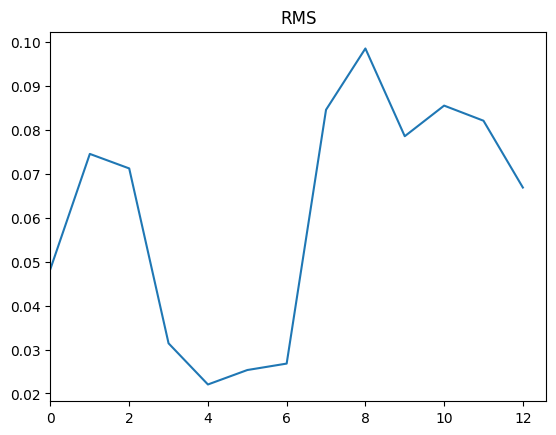

In [34]:
import matplotlib.pyplot as plt
from pylab import plot, show, figure, imshow

# PLOT RMS
plot(rms_values)
plt.title("RMS")
plt.xlim(0)
show()

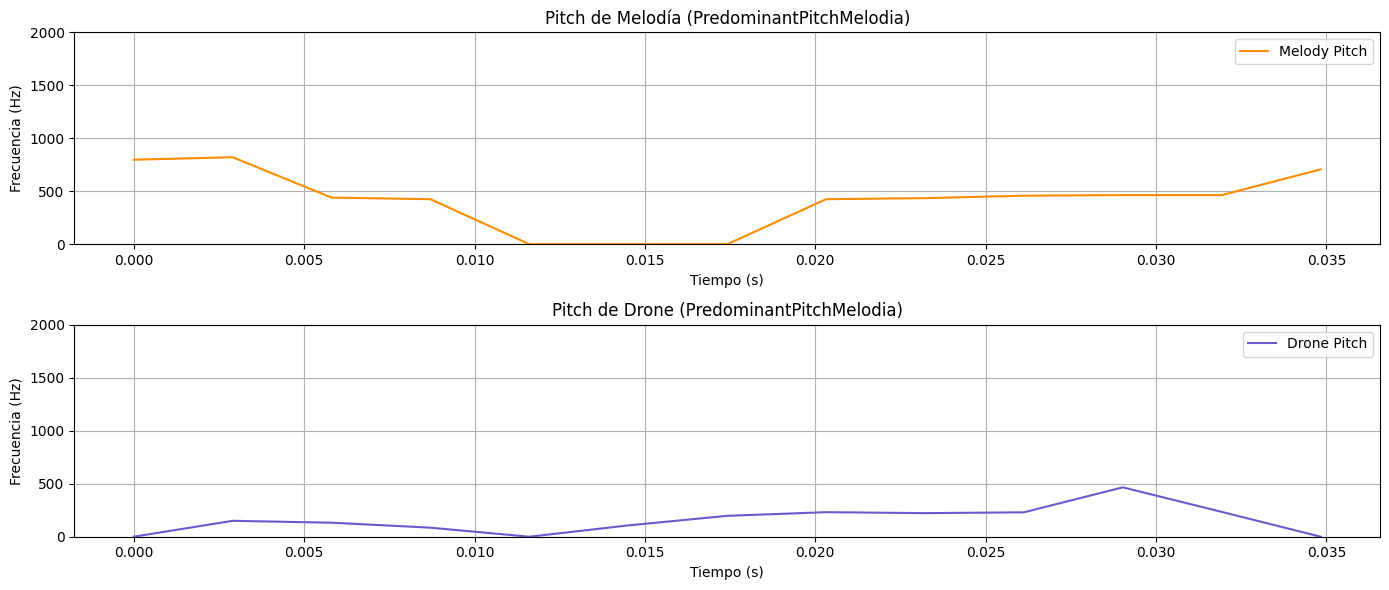

In [35]:
#PLOT D'EXTRCCIÓNS DE PITCH

import matplotlib.pyplot as plt
from pylab import plot, show, figure, imshow

pitch_values_single = np.array(pitch_values)
pitch_values_drone = np.array(pitch_values_drone)
hop_size=128
sample_rate=44100
#pitch_values_drone = valid_pitches

# Calcular els temps
times_melody = np.arange(len(pitch_values_single)) * hop_size / sample_rate
times_drone = np.arange(len(pitch_values_drone)) * hop_size / sample_rate
#times_drone = np.arange(len(valid_pitches)) * hop_size / sample_rate #VALID_PITCHES = frequencies que concorden amb la nota DRONE

# Crear figura
plt.figure(figsize=(14, 6))

# === SUBPLOT 1: PITCH MELODÍA ===
plt.subplot(2, 1, 1)
plt.plot(times_melody, pitch_values_single, color='darkorange', label='Melody Pitch')
plt.title('Pitch de Melodía (PredominantPitchMelodia)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.grid(True)
plt.ylim(0, 2000)
plt.legend()

# === SUBPLOT 2: PITCH DRONE ===
plt.subplot(2, 1, 2)
#plt.plot(times_drone, pitch_values_drone, color='slateblue', label='Drone Pitch')
plt.plot(times_drone, pitch_values_drone, color='slateblue', label='Drone Pitch')
plt.title('Pitch de Drone (PredominantPitchMelodia)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.grid(True)
plt.ylim(0, 2000)
plt.legend()

plt.tight_layout()
plt.show()
